In [57]:
import boto3
import pandas as pd

bucket = "ml-for-bem"
bucket_prefix = "hatchet"
experiment_id = "test/progressive-training-22"

s3 = boto3.client("s3")

# list all the files in the experiment directory that have "train" and "results" and "h5" in the key
files = s3.list_objects(Bucket=bucket, Prefix=f"{bucket_prefix}/{experiment_id}")[
    "Contents"
]

# filter the files to only include the ones that have "train" and "results" and "h5" in the key
train_results_files = [
    file
    for file in files
    if "train/" in file["Key"] and "results" in file["Key"] and "h5" in file["Key"]
]
sample_results_files = [file for file in files if "full-dataset.pq" in file["Key"]]


file_keys = [file["Key"] for file in train_results_files]
import tempfile
from pathlib import Path

all_dfs = []
with tempfile.TemporaryDirectory() as temp_dir:
    for i, file in enumerate(file_keys):
        local_path = Path(temp_dir) / f"result_{i}.h5"
        s3.download_file(Bucket=bucket, Key=file, Filename=local_path.as_posix())
        df = pd.read_hdf(local_path.as_posix(), key="stratum_metrics")
        all_dfs.append(df)

err_dfs = pd.concat(all_dfs)


In [59]:
(
    err_dfs.groupby("progressive_training_iter_ix")
    .mean()["test"]
    .xs("mae", level="metric", axis=1)
    .T
).round(2).groupby("target").max()
# plt.ylim(0,1)

progressive_training_iter_ix,0,1,2,3,4,5
target,,,,,,
District Cooling,11.18,7.67,6.50,5.58,5.69,4.87
District Heating,12.47,9.23,8.06,7.21,6.68,5.66
Domestic Hot Water,0.01,0.01,0.01,0.01,0.01,0.01
Electricity,0.26,0.17,0.16,0.14,0.12,0.10


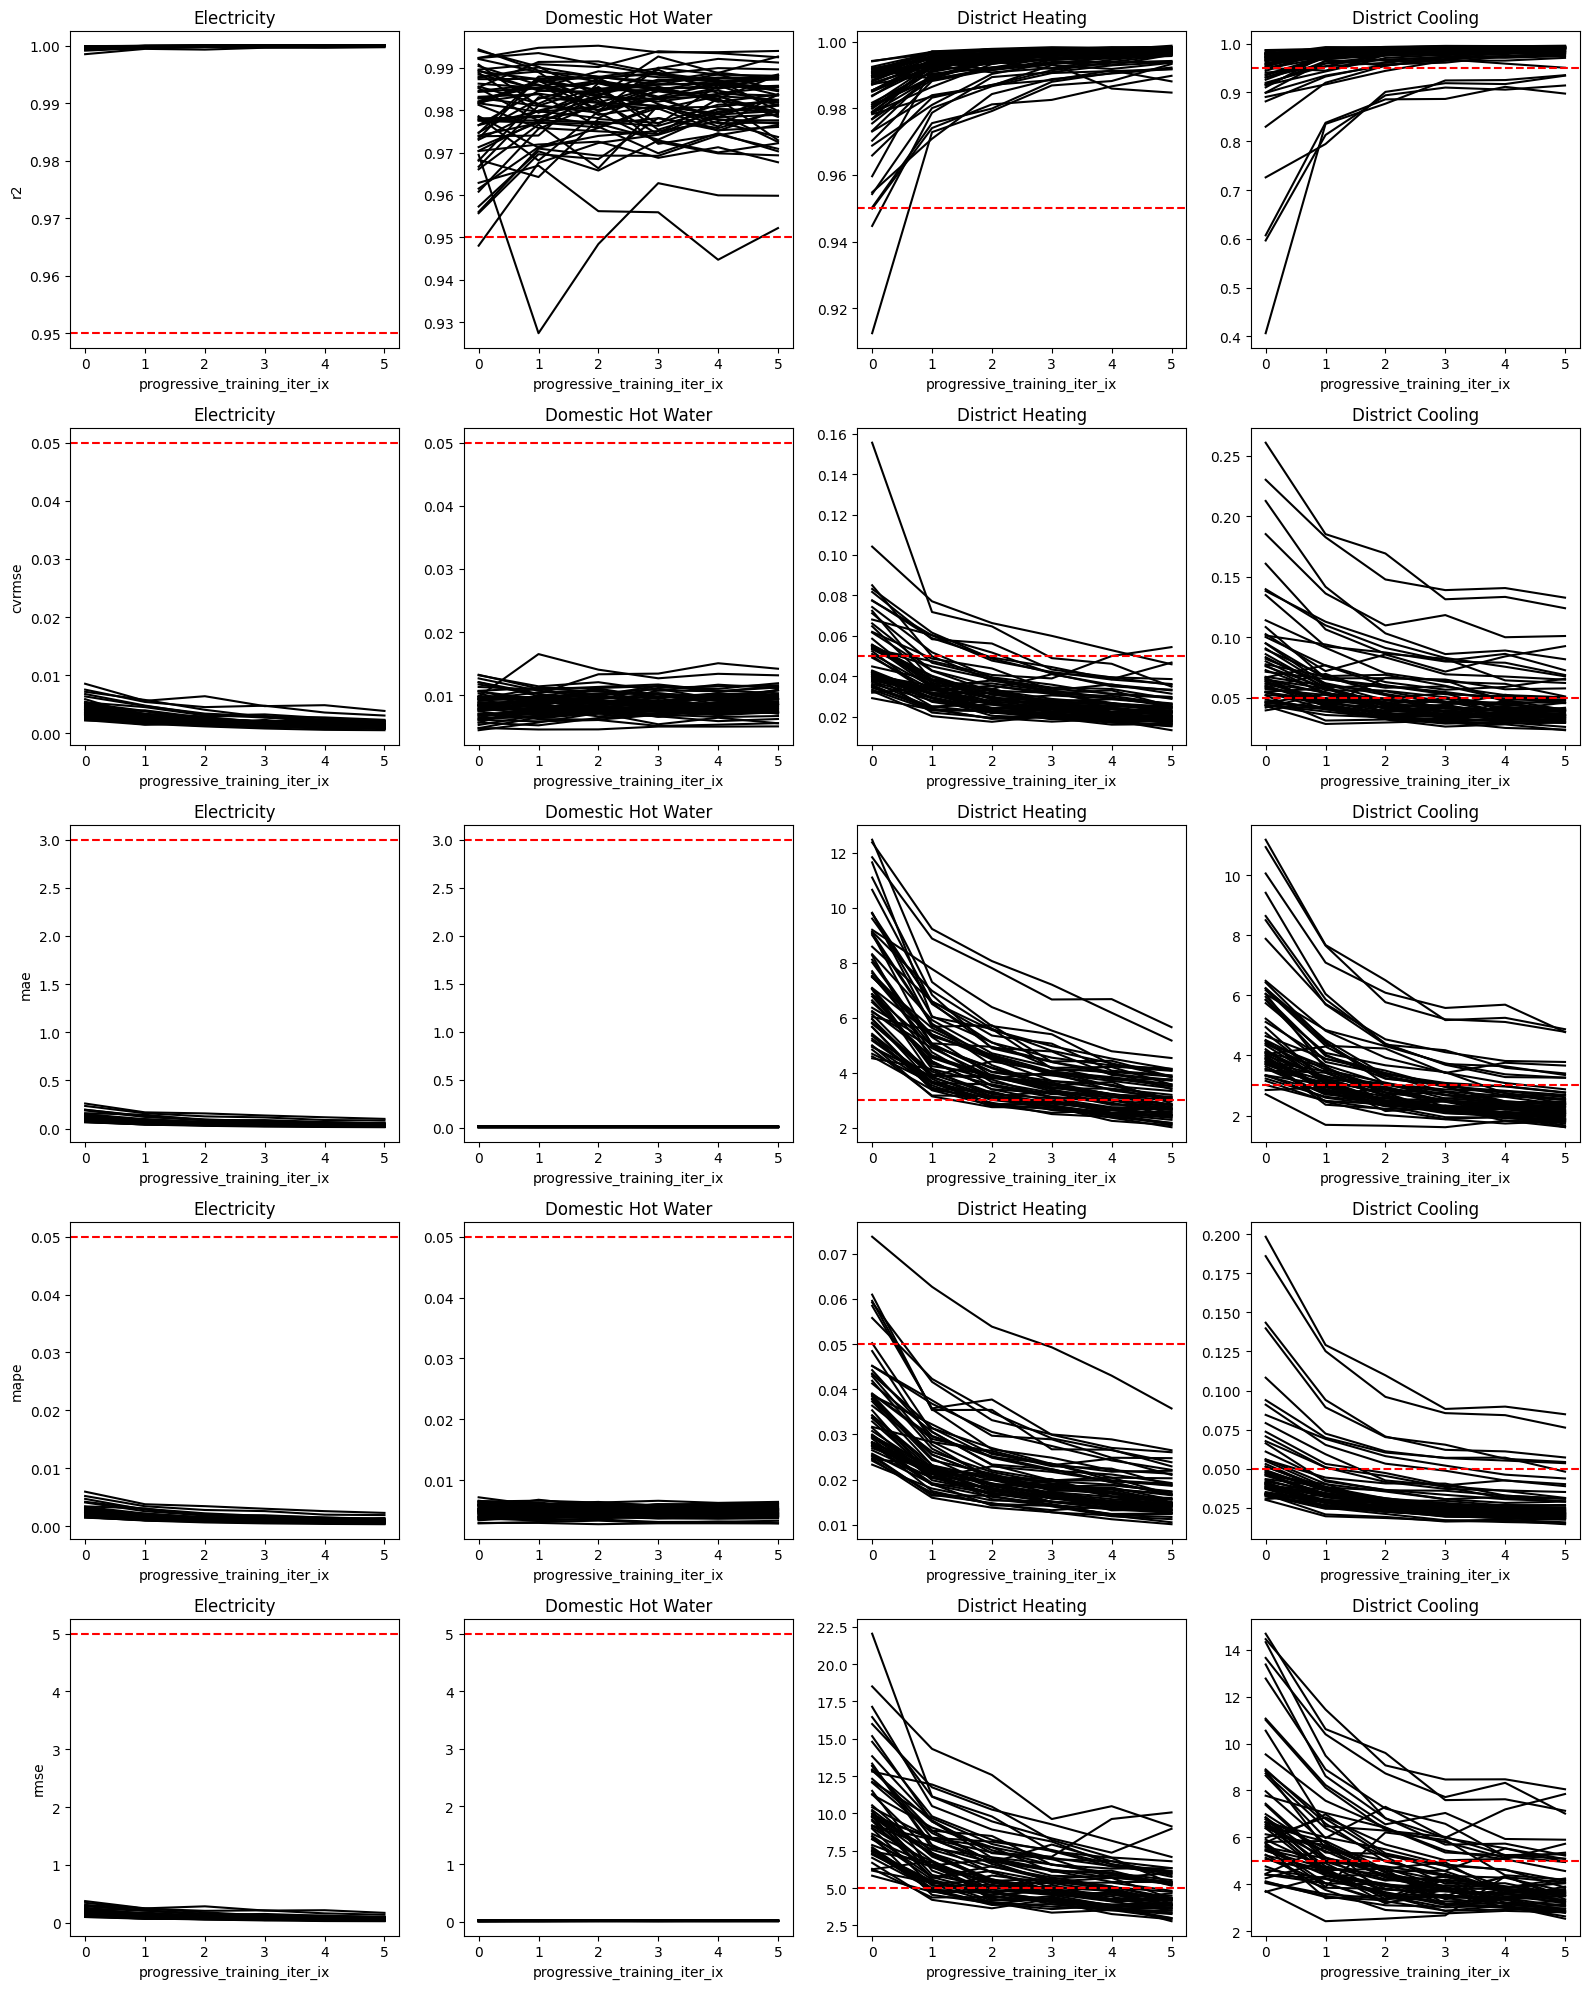

In [61]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "rmse": 5,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 4, figsize=(16, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Electricity",
        "Domestic Hot Water",
        "District Heating",
        "District Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            err_dfs.groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(legend=False, ax=ax, color="black")
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

feature.semantic.Ventilation
BasicHRV      83.995215
BasicNat      83.885257
BasicNoHRV    87.468060
Name: District Heating, dtype: float64

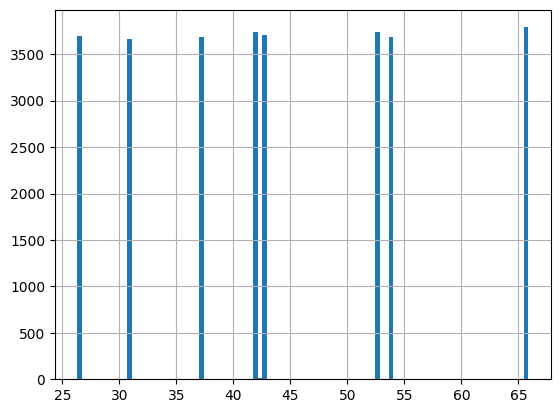

In [62]:
key = sample_results_files[-1]["Key"]
df = pd.read_parquet(f"s3://{bucket}/{key}")
df["Electricity"].hist(bins=100)
# sorted(df["Electricity"].round(0).values.tolist())
len(df), df["Electricity"].round(0).nunique()
df["Electricity"].groupby(["Typology", "Equipment", "Lighting"]).std()
df["Domestic Hot Water"].groupby(["Typology"]).std()
df["District Heating"].groupby(["feature.semantic.Ventilation"]).std()


<Axes: >

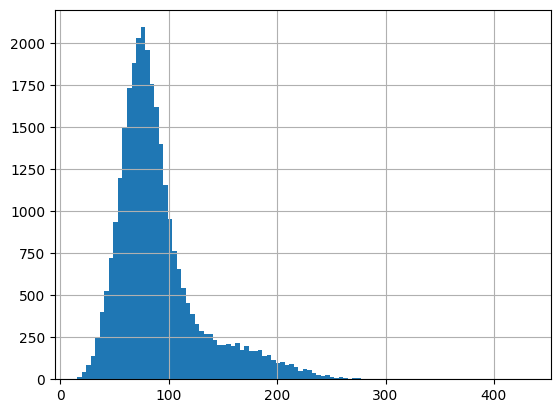

In [64]:
df["District Cooling"].hist(bins=100)

In [66]:
from epengine.models.train_sbem import TrainFoldSpec

spec = TrainFoldSpec(
    n_folds=5,
    data_uri=f"s3://{bucket}/{key}",
    stratification_field="feature.weather.file",
    progressive_training_iter_ix=0,
    experiment_id=experiment_id,
    sort_index=0,
)


In [67]:
import numpy as np

train_features, train_targets = spec.train_segment
normalized_features = spec.normalize_params(train_features)
for col in normalized_features.columns:
    try:
        col_vals = normalized_features[col].values.astype(float)
        district_heating = train_targets["District Heating"].values
        correlation = np.corrcoef(col_vals, district_heating)[0, 1]
        print(f"{col}: {correlation}")
    except Exception as e:
        print(type(col_vals))
        print(f"{col} ERROR {e}")


feature.geometry.long_edge: -0.35249490019716845
feature.geometry.short_edge: -0.3734921707198969
feature.geometry.orientation: -0.007495378564016553
feature.geometry.orientation.cos: -0.020555054704501707
feature.geometry.orientation.sin: -0.003591052888278095
feature.geometry.aspect_ratio: -0.0446709023203929
feature.geometry.rotated_rectangle_area_ratio: -0.2505956290295944
feature.geometry.wwr: nan
feature.geometry.height: -0.1534122060827346
feature.geometry.num_floors: -0.1534122060827346
feature.geometry.f2f_height: nan
feature.geometry.shading_mask_00: 0.06986223789165487
feature.geometry.shading_mask_01: 0.06472397777517251
feature.geometry.shading_mask_02: 0.05889274999581485
feature.geometry.shading_mask_03: 0.058930864361399056
feature.geometry.shading_mask_04: 0.058629962700770304
feature.geometry.shading_mask_05: 0.054799339002947076
feature.geometry.shading_mask_06: 0.050554609436731755
feature.geometry.shading_mask_07: 0.047363080063833746
feature.geometry.shading_mask_

E:\repos\epengine\epengine\models\train_sbem.py:657: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.         0.         0.05555556]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fparams.loc[:, col] = (fparams.loc[:, col] - min_val) / (
E:\repos\epengine\epengine\models\train_sbem.py:662: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fparams[col] = pd.Categorical(
e:\repos\epengine\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\repos\epengine\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046

In [68]:
train_targets.groupby("feature.semantic.Ventilation").mean()

ColumnName,Electricity,District Cooling,District Heating,Domestic Hot Water
feature.semantic.Ventilation,,,,
BasicHRV,44.285454,95.149025,190.935473,1.525653
BasicNat,43.944363,80.319062,171.484263,1.525755
BasicNoHRV,43.843638,96.161609,236.003839,1.525085


In [ ]:
import xgboost as xgb

xgb_hyperparams = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 5,  # 7
    "eta": 0.1,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    # "alpha": 0.01,
    # "lambda": 0.01,
    # "gamma": 0.01,
}

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)

train_dmatrix = xgb.DMatrix(train_features_norm, label=train_targets)
test_dmatrix = xgb.DMatrix(test_features_norm, label=test_targets)

model = xgb.train(
    xgb_hyperparams,
    train_dmatrix,
    num_boost_round=2000,
    evals=[(test_dmatrix, "eval")],
    early_stopping_rounds=20,
)


[0]	eval-rmse:79.55615
[1]	eval-rmse:72.02913
[2]	eval-rmse:66.20087
[3]	eval-rmse:60.05912
[4]	eval-rmse:54.68587


E:\repos\epengine\epengine\models\train_sbem.py:657: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.         0.         0.05555556]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fparams.loc[:, col] = (fparams.loc[:, col] - min_val) / (
E:\repos\epengine\epengine\models\train_sbem.py:662: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fparams[col] = pd.Categorical(
E:\repos\epengine\epengine\models\train_sbem.py:657: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.05555556 ... 0.05555556 0.         0.  

[5]	eval-rmse:49.75762
[6]	eval-rmse:45.34456
[7]	eval-rmse:42.09789
[8]	eval-rmse:39.16580
[9]	eval-rmse:35.89367
[10]	eval-rmse:32.98277
[11]	eval-rmse:31.00835
[12]	eval-rmse:28.63449
[13]	eval-rmse:26.53679
[14]	eval-rmse:25.11654
[15]	eval-rmse:23.43683
[16]	eval-rmse:21.93123
[17]	eval-rmse:20.93445
[18]	eval-rmse:19.69593
[19]	eval-rmse:18.89726
[20]	eval-rmse:17.95071
[21]	eval-rmse:17.05567
[22]	eval-rmse:16.35862
[23]	eval-rmse:15.67802
[24]	eval-rmse:15.07641
[25]	eval-rmse:14.62675
[26]	eval-rmse:14.09041
[27]	eval-rmse:13.70264
[28]	eval-rmse:13.39843
[29]	eval-rmse:12.94435
[30]	eval-rmse:12.63083
[31]	eval-rmse:12.38861
[32]	eval-rmse:12.15612
[33]	eval-rmse:12.00645
[34]	eval-rmse:11.84162
[35]	eval-rmse:11.33281
[36]	eval-rmse:11.11909
[37]	eval-rmse:11.01324
[38]	eval-rmse:10.80968
[39]	eval-rmse:10.68201
[40]	eval-rmse:10.61283
[41]	eval-rmse:10.28098
[42]	eval-rmse:10.17321
[43]	eval-rmse:10.08773
[44]	eval-rmse:9.92284
[45]	eval-rmse:9.65561
[46]	eval-rmse:9.52028


In [145]:
import asyncio

from archetypal.idfclass import IDF
from epinterface.geometry import match_idf_to_building_and_neighbors

from epengine.models.shoebox import ShoeboxSimulationSpec

df_old = pd.read_parquet(
    "s3://ml-for-bem/hatchet/massachusetts/2024_09_30/residential-v2/specs/832ee29a-1a76-4126-9c83-f08171b5899a/832ee29a-1a76-4126-9c83-f08171b5899a_specs_000000.pq"
)
k = 17
spec_old = ShoeboxSimulationSpec(**df_old.iloc[k].to_dict())

f2f_height = 3.5
model = spec_old.configure(f2f_height=f2f_height)
model.geometry.w, model.geometry.d = model.geometry.d, model.geometry.w

# create a global variable to cache the idf
my_idf: IDF | None = None


def post_build_callback(idf: IDF) -> IDF:
    idf = match_idf_to_building_and_neighbors(
        idf,
        building=spec_old.rotated_rectangle,
        neighbor_polys=spec_old.neighbor_polys,  # pyright: ignore [reportArgumentType]
        neighbor_floors=spec_old.neighbor_floors,  # pyright: ignore [reportArgumentType]
        neighbor_f2f_height=f2f_height,
        target_long_length=spec_old.long_edge,
        target_short_length=spec_old.short_edge,
        rotation_angle=spec_old.long_edge_angle,
    )
    global my_idf
    my_idf = idf
    return idf


weather_dir = Path("notebooks") / "weather"
weather_dir.mkdir(parents=True, exist_ok=True)
from epinterface.climate_studio.builder import SimulationPathConfig

temp_dir = Path("cache") / "temptest"
output_dir = Path(temp_dir)
config = (
    SimulationPathConfig(
        output_dir=output_dir,
        weather_dir=weather_dir,
    )
    if weather_dir is not None
    else SimulationPathConfig(output_dir=output_dir)
)

try:
    idf, sql = await asyncio.to_thread(
        model.simulate,
        config=config,
        post_build_callback=post_build_callback,
    )
except Exception as e:
    print(e)


Adding lights to zone with schedule MA_LIGHTS_SCHEDULE.  Make sure this schedule exists.
Ignoring IlluminanceTarget for zone(s) Conditioned_Zones.
Adding people to zone with schedule MA_OCC_SCH.  Make sure this schedule exists.
Ignoring AirspeedSchedule for zone(s) Conditioned_Zones.
Adding equipment to zone with schedule MA_EQUIP_SCHEDULE.  Make sure this schedule exists.
Mechanical ventilation schedule is being ignored in zone Block shoebox Storey 0.
Exception in thread ExpandObjects_Minimal.idf:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\repos\epengine\.venv\lib\site-packages\archetypal\eplus_interface\expand_objects.py", line 63, in run
    self.p = subprocess.Popen(
  File "C:\tools\Anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\Anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid

C:\EnergyPlusV22-2-0\energyplus.exe Minimal.idf: 0it [00:00, ?it/s]

e:\repos\epengine\notebooks\cache\temptest\Minimal.idf:
Program Version,EnergyPlus, Version 22.2.0-c249759bad, YMD=2025.03.19 13:24,
   ** Severe  ** HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   **   ~~~   ** You must run the ExpandObjects program on this input.
   **  Fatal  ** Errors occurred on processing input file. Preceding condition(s) cause termination.
   ...Summary of Errors that led to program termination:
   ..... Reference severe error count=1
   ..... Last severe error=HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   ************* Warning:  Node connection errors not checked - most system input has not been read (see previous warning).
   ************* Fatal error -- final processing.  Program exited before simulations began.  See previous error messages.
   ************* EnergyPlus Warmup Error Summary. During Warmup: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Sizing Error Su

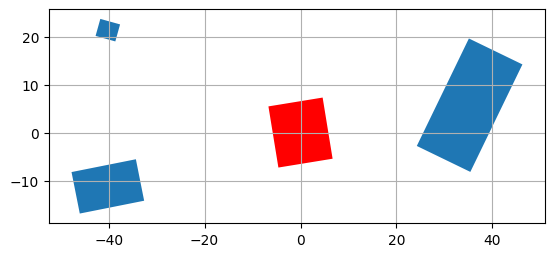

In [146]:
from shapely import from_wkt

rotated_rectangle = from_wkt(spec_old.rotated_rectangle)
neighbor_polys = [from_wkt(poly) for poly in spec_old.neighbor_polys]
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ne = gpd.GeoSeries(neighbor_polys)
bu = gpd.GeoSeries(rotated_rectangle)
ne.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(ax=ax)
bu.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(
    ax=ax, color="red"
)
ax.grid()

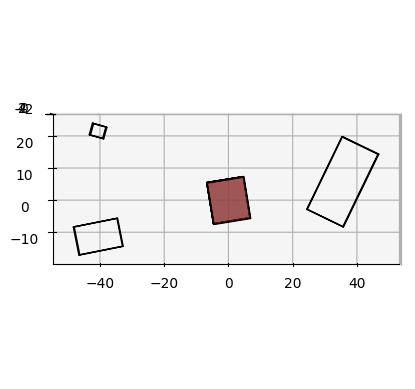

In [147]:
from geomeppy.view_geometry import _get_collection, _get_surfaces

surfaces = _get_surfaces(my_idf)
# set up the collections
walls = _get_collection("wall", surfaces, 0.5, facecolor="lightyellow")
floors = _get_collection("floor", surfaces, 0.5, facecolor="dimgray")
roofs = _get_collection("roof", surfaces, 0.5, facecolor="firebrick")
windows = _get_collection("window", surfaces, 0.5, facecolor="cornflowerblue")
shading = _get_collection("shading", surfaces, 1, facecolor="darkolivegreen")

ax = plt.axes(projection="3d")
ax.add_collection3d(floors)
ax.add_collection3d(walls)
ax.add_collection3d(roofs)
ax.add_collection3d(windows)
ax.add_collection3d(shading)
ax.view_init(elev=90, azim=-90)
ax.set_aspect("equal")
# set the view to be in plane, i.e. from above


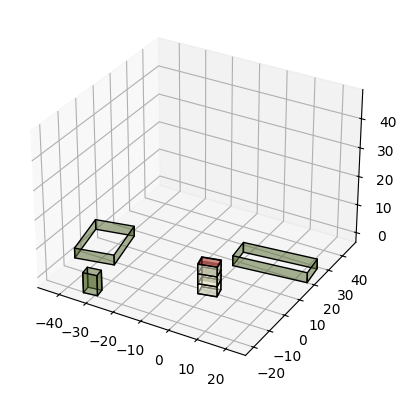

In [136]:
fig, ax = my_idf.view_model()
